# Selection network architecture with genetics algorithm

This notebook is inspired by the following paper: [Efficient Architecture Search for Deep Neural Networks](https://www.sciencedirect.com/science/article/pii/S1877050920303859)

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import copy
from collections import OrderedDict
from scripts import utils

%load_ext autoreload
%autoreload 2

### Import dataset

In [2]:
from scripts import cifar10
trainloader, testloader, classes = cifar10.cifar10()

Files already downloaded and verified
Files already downloaded and verified


### Define basic network

In [51]:
utils.compute_output_conv2d((32,32), kernel_size=(3,3), padding=(1,1), stride=(1,1), dilation=(1,1))

(32, 32)

In [18]:

utils.compute_output_conv2d(32, kernel_size=1, padding=0, stride=1, dilation=1)

32

In [27]:
class _Chromotype():
    def __init__(self, num_layers, num_input, num_output, inerithance=None):
        self.num_layers = num_layers
        self.num_input = num_input
        self.num_output = num_output
        

        #define chromosome types
        self.lchromosomes = [
                            nn.Conv2d(num_input, num_output, kernel_size=1, padding=0),
                            nn.Conv2d(num_input, num_output,
                                           kernel_size=3, stride=1, padding=1,
                                           bias=False),
                            nn.Conv2d(num_input, num_output,
                                           kernel_size=5, stride=1, padding=2 ,groups=2,
                                           bias=False),
                            nn.Conv2d(num_input, num_output,
                                           kernel_size=7, stride=1, padding=3 ,groups=2,
                                           bias=False),
                            nn.Conv2d(num_input, num_output,
                                            kernel_size=3, stride=1, padding=1 ,groups=2,  dilation=1,
                                            bias=False)
                            ]
        self.number_of_genes = len(self.lchromosomes)
                            
        if(inerithance is None):
            self.config = []
            for i in range(self.num_layers):
                self.config.append(np.random.randint(0, self.number_of_genes))
            self.config = np.array(self.config)
            
    def get_chromotype(self, el):
        if el>= self.number_of_genes:
            raise ValueError("chromosome index out of range")
        return self.lchromosomes[el]
    


In [24]:
dna = _Chromotype(5, 3, 10)
print(dna.config)
dna.get_chromotype(0)

ValueError: in_channels must be divisible by groups

Test the network:

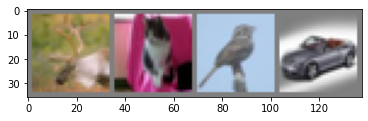

torch.Size([4, 10])


In [31]:
images , classes = next(iter(trainloader))

def imgshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imgshow(torchvision.utils.make_grid(images))
print(net(images).shape)

### Define chromosomes

In this version each image will feed in the whole network with different kernel size. The kernel size will be selected by the genetic algorithm.

In [149]:
chromo = [ [nn.Conv2d(3,3,kernel_size=(1,3) ), nn.ReLU(), nn.BatchNorm2d(3), nn.Conv2d(3,3,kernel_size=(3,1))], [nn.Conv2d(3,3,kernel_size=(1,7)),nn.ReLU(), nn.BatchNorm2d(3), nn.Conv2d(3,3,kernel_size=(7,1))], 
[nn.Conv2d(3,3,3)], [nn.Conv2d(3,3,3, dilation=2)], [nn.Conv2d(3,3,1)] ]   # mancano le depthwise convolution 

Create an instance of the network with the corresponding chromosome:

In [154]:
copia = copy.deepcopy(chromo)
print(copia[0:2])
individual = Individual(copia[0:2])

[[Conv2d(3, 3, kernel_size=(1, 3), stride=(1, 1)), ReLU(), BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Conv2d(3, 3, kernel_size=(3, 1), stride=(1, 1))], [Conv2d(3, 3, kernel_size=(1, 7), stride=(1, 1)), ReLU(), BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Conv2d(3, 3, kernel_size=(7, 1), stride=(1, 1))]]
BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
ReLU()
AvgPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0)
BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d(3, 3, kernel_size=(1, 3), stride=(1, 1))
ReLU()
BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d(3, 3, kernel_size=(3, 1), stride=(1, 1))
ReLU()
BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1))
ReLU()
AvgPool2d(kernel_size=(2, 2), s

In [110]:
print(copia[0:3])

[[Conv2d(3, 3, kernel_size=(3, 3), stride=(1, 1)), Conv2d(3, 3, kernel_size=(3, 1), stride=(1, 1)), BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1)), ReLU(), MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)], [Conv2d(3, 3, kernel_size=(1, 7), stride=(1, 1)), Conv2d(3, 3, kernel_size=(7, 1), stride=(1, 1)), BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), Conv2d(3, 3, kernel_size=(1, 1), stride=(1, 1)), ReLU(), MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)]]


Plot the the output of the network: